In [1]:
import pandas
import datetime
import time
import feather
import numpy
from aacgmv2 import convert_mlt
from davitpy import utils
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,5,16)
timeStart = datetime.datetime(2011,5,16,7,55)
selTime = datetime.datetime(2011,5,16,8,20) 
timeEnd = datetime.datetime(2011,5,16,9,0)
plotMlatRange = [ 50., 70. ]
anlyzCoords = 'mlt'
velScale = [ 0., 250. ]
saisVelCutoff = 50.
# Plotting SAPS vels arrows
arrowLenFactor = 8

In [3]:
# read from the feather file
fitsDF = feather.read_dataframe('../data/lshell-fits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
# set a few filters to the data
# 1) azim should be -90+/-cutoff
# fitsDF = fitsDF[ numpy.abs( fitsDF["azimSAPS"] ) < azimCutoff ]
# Calculate details for plotting arrows
# We plot the arrows on the time axis, so instead of normMLT
# we'll use time to estimate the end points of the vectors!
fitsDF["time"] = fitsDF["date"].map(lambda x:(x.hour + x.minute/60.)*arrowLenFactor)
# Need three MLATs (min, med and max) if you we want to plot
# the latitudinal extent of the flows!
fitsDF["endPtMedMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["medLat"], 2)
fitsDF["endPtMinMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["minLat"], 2)
fitsDF["endPtMaxMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["maxLat"], 2)
# We can have just one MLT
fitsDF["endPtTime"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) *\
             numpy.sin( numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) )\
              + fitsDF["time"], 2)
fitsDF.head()

,azimSAPS,azimSTD,date,maxLat,maxMLT,medLat,medMLT,minLat,minMLT,velSAPS,velSTD,time,endPtMedMLAT,endPtMinMLAT,endPtMaxMLAT,endPtTime
0,19.768236,0.931059,2011-05-16 07:48:00,59.6174,-0.7280,57.90760,-1.83125,56.1310,-2.0897,129.714436,3.522145,62.400000,57.86,56.09,59.57,62.28
1,20.427979,3.131936,2011-05-16 08:02:00,59.1016,-0.5264,57.59150,-1.65780,56.1310,-2.3693,140.303240,12.444799,64.266667,57.54,56.08,59.05,64.14
2,20.029809,3.104352,2011-05-16 08:04:00,59.1999,-0.5324,57.77460,-1.62230,56.1979,-2.3361,146.497726,13.082398,64.533333,57.72,56.15,59.15,64.40
3,19.922040,2.151380,2011-05-16 08:06:00,59.6040,-0.4981,57.94995,-1.58405,56.1979,-1.8762,167.429700,9.992434,64.800000,57.89,56.14,59.55,64.64
4,19.473456,1.896487,2011-05-16 08:08:00,59.9090,-0.4070,58.10670,-1.56180,56.1979,-1.9634,181.309917,9.356487,65.066667,58.05,56.14,59.85,64.90


In [4]:
def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )



In [5]:
inpColList = [ "dateStr", "timeStr", "Mlat",\
              "Mlon", "med_tec", "dlat", "dlon" ]
inpFile = "../data/tec-medFilt-" + eventDate.strftime("%Y%m%d") + ".txt"
medFiltTECDF = pandas.read_csv(inpFile, delim_whitespace=True,\
                                    header=None, names=inpColList)
medFiltTECDF["date"] = medFiltTECDF.apply( convert_to_datetime, axis=1 )
medFiltTECDF["MLT"] = [ convert_mlt( mlon, ts , m2a=False ) \
                       for (mlon,ts) in zip(medFiltTECDF["Mlon"],\
                                            medFiltTECDF["date"]) ]
medFiltTECDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date,MLT
0,20110516,10,11.0,0.0,15.0,1.0,2.0,2011-05-16 00:10:00,19.593833
1,20110516,10,11.0,2.0,15.0,1.0,2.0,2011-05-16 00:10:00,19.727166
2,20110516,10,11.0,32.0,7.0,1.0,2.0,2011-05-16 00:10:00,21.727166
3,20110516,10,11.0,34.0,6.6,1.0,2.0,2011-05-16 00:10:00,21.860500
4,20110516,10,11.0,36.0,6.3,1.0,2.0,2011-05-16 00:10:00,21.993833


/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


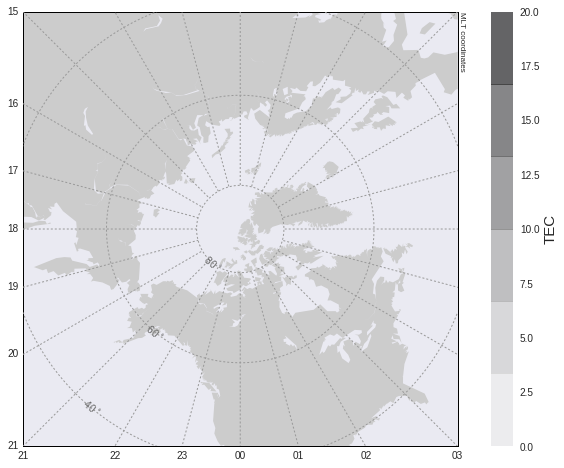

In [6]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Greys"))
selTecDF = medFiltTECDF[ medFiltTECDF["date"] == selTime ].reset_index(drop=True)

# flatui = ["#3182bd", "#9ecae1", "#7fcdbb", "#ffeda0", "#feb24c", "#f03b20"]
# sns.set_palette(flatui)
# seaMap = ListedColormap( sns.color_palette() )
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=40., gridLabels=True,\
                            coords=anlyzCoords, ax=ax, datetime=selTime, lon_0=0)
xVec, yVec = m1(selTecDF["MLT"].values*15, selTecDF["Mlat"].values, coords=anlyzCoords)

tecPlot = m1.scatter( xVec, yVec , c=selTecDF["med_tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s", vmin=0., vmax=20. )


cbar = plt.colorbar(tecPlot, orientation='vertical')
cbar.set_label('TEC', size=15)

In [7]:
# We'll get the min TEC at the trough
trghMinDF = medFiltTECDF[ ((medFiltTECDF["Mlat"] <= plotMlatRange[1]) &\
                       (medFiltTECDF["Mlat"] >= plotMlatRange[0])) ]
trghMinDF["MLTrnd"] = trghMinDF["MLT"].round()
trghMinTECDF = trghMinDF[ ["MLTrnd", "date", "med_tec"]\
                     ].groupby(["MLTrnd", "date"]).min().reset_index()
trghMinTECDF.columns = ["MLTrnd", "date", "min_tec"]
trghMinDF = pandas.merge( trghMinDF, trghMinTECDF,\
                         left_on=["MLTrnd", "date", "med_tec"],\
                        right_on=["MLTrnd", "date", "min_tec"])
# Now there could be multiple locations with min tec value
# get the median MLAT location in that case!!!
trghMinDF = trghMinDF[ [ "date", "Mlat",\
                        "med_tec", "min_tec", "MLTrnd" ] ]
trghMinDF = trghMinDF.groupby( [ "date", "med_tec", \
                        "min_tec", "MLTrnd" ] ).min().reset_index()
trghMinDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,med_tec,min_tec,MLTrnd,Mlat
0,2011-05-16 00:10:00,1.4,1.4,22.0,68.0
1,2011-05-16 00:10:00,1.6,1.6,24.0,68.0
2,2011-05-16 00:10:00,1.7,1.7,0.0,70.0
3,2011-05-16 00:10:00,1.9,1.9,1.0,70.0
4,2011-05-16 00:10:00,1.9,1.9,23.0,66.0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


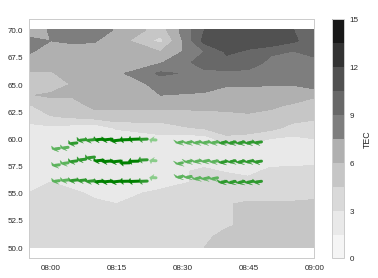

In [8]:
# Some temp constants
plotMltChsn = 23
if plotMltChsn > 12:
    pltNormMLTChsn = plotMltChsn - 24.
else:
    pltNormMLTChsn = plotMltChsn
colNorm = Normalize( vmin=velScale[0], vmax=velScale[1] )
nrstMLTCutoff = 0.1
plotmed_tecCutoff = 0.0
ticks = numpy.linspace(0,15,11)
# set a few standard xticks
xTickList = []
currTime = timeStart + datetime.timedelta(minutes=5)
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plotting
seaMap = ListedColormap(sns.color_palette("Greys",11))


sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = medFiltTECDF[ ((medFiltTECDF["date"] >= timeStart) &\
                       (medFiltTECDF["date"] <= timeEnd) &\
                    (medFiltTECDF["Mlat"] <= plotMlatRange[1]) &\
                       (medFiltTECDF["Mlat"] >= plotMlatRange[0]) )]

# Now we don't have exact MLT
# so we'll get mean TEC values
# by rounding MLTs to nearest int
# selDF = selDF[ numpy.abs( selDF["MLT"] - plotMltChsn ) <= nrstMLTCutoff ].reset_index(drop=True)
selDF["MLTRnd"] = selDF["MLT"].round()
selDF = selDF[ selDF["MLTRnd"] == plotMltChsn ]
selDF["time"] = [ date2num(x) for x in selDF["date"] ]
selDF = selDF[ ["Mlat", "time", "med_tec"]\
             ].groupby( ["Mlat", "time"] ).median().reset_index()

plotmedFiltTECDF = selDF[ ["Mlat", "time",\
                        "med_tec"] ].pivot( "Mlat", "time" )


mlatVals = plotmedFiltTECDF.index.values
timeVals = plotmedFiltTECDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
med_tecVals = numpy.ma.masked_where(numpy.isnan(plotmedFiltTECDF["med_tec"].values),plotmedFiltTECDF["med_tec"].values)
ampPlot = ax.pcolormesh(timeCntr, mlatCntr,med_tecVals.T,cmap=seaMap)
ampPlot = ax.contourf(timeCntr, mlatCntr,med_tecVals.T, ticks,cmap=seaMap)
# ax.contour(timeCntr, mlatCntr,med_tecVals.T, numpy.linspace(0,10,9),
#                  origin='lower',
#                  linewidths=0.5,colors='k')
cbar = plt.colorbar(ampPlot)
cbar.set_label("TEC")

# selMinDF = trghMinDF[ ((trghMinDF["MLTrnd"] == plotMltChsn) &\
#                        (trghMinDF["date"] >= timeStart) &\
#                       (trghMinDF["date"] <= timeEnd) ) ]
# ax.plot( selMinDF["date"].values, selMinDF["Mlat"].values, 'r.' )

# print selMinDF[ selMinDF["date"] == timeStart + datetime.timedelta(minutes=5) ]

ax.set_xticks(xTickList)

ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# Plot SD data
seaMap = ListedColormap( sns.light_palette("green") )
ax2 = ax.twiny()
for index, row in fitsDF.iterrows():
    currCol = seaMap( colNorm(row['velSAPS']) )
    if row['velSAPS'] < saisVelCutoff:
        currCol = "#636363"
    # Min Lat Loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["minLat"],\
                row['endPtMinMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["minLat"], row["endPtTime"]-row["time"], row['endPtMinMLAT']-row["minLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
    # Median Lat Loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["medLat"],\
                row['endPtMedMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["medLat"], row["endPtTime"]-row["time"], row['endPtMedMLAT']-row["medLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
    # Max Lat loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["maxLat"],\
                row['endPtMaxMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["maxLat"], row["endPtTime"]-row["time"], row['endPtMaxMLAT']-row["maxLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
# Need to carefully set the x-axis
ax2.set_xlim([(timeStart.hour + timeStart.minute/60.)*arrowLenFactor,\
              (timeEnd.hour + timeEnd.minute/60.)*arrowLenFactor])
ax2.axis('off')
fig.savefig( "../plots/tec-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

In [9]:
ampSCWDF = feather.read_dataframe('../data/amp-scw-' +\
                eventDate.strftime("%Y%m%d") + '.feather')

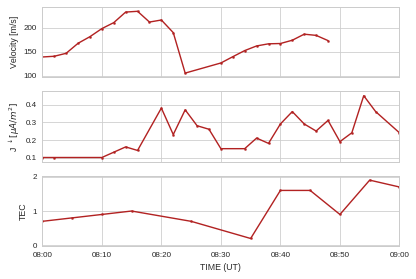

In [12]:
selMLTs = [23]
sns.set_style("whitegrid")
sns.set_context("paper")
colList = [ "firebrick", "seagreen", "#2c7fb8" ]

fig = plt.figure()
f, axArr = plt.subplots(3, sharex=True)

for nm, mm in enumerate(selMLTs):
    selTECDF = trghMinDF[ (trghMinDF["date"] >= timeStart) &\
                        (trghMinDF["date"] <= timeEnd)  &\
                       (trghMinDF["MLTrnd"] == mm) ]
    if mm > 12.:
        normM = mm -24.
    else:
        normM = mm
    selVelDF = fitsDF#[ fitsDF["mltSAPS"] == normM ]
    selAmpDF = ampSCWDF#[ ampSCWDF["scwMLTDown"] == mm ]
    # plot VELS
    axArr[0].plot( selVelDF["date"].values, selVelDF["velSAPS"].values, color=colList[nm], label=str(mm) + " MLT" )
    axArr[0].scatter( selVelDF["date"].values, selVelDF["velSAPS"].values, color=colList[nm], s=5 )
    # plot AMP
    axArr[1].plot( selAmpDF["scwLocDates"].values, numpy.abs(selAmpDF["scwJrDown"].values), color=colList[nm], label=str(mm) + " MLT" )
    axArr[1].scatter( selAmpDF["scwLocDates"].values, numpy.abs(selAmpDF["scwJrDown"].values), color=colList[nm], s=5)
    # plot TEC Min
    axArr[2].plot( selTECDF["date"].values, selTECDF["min_tec"].values, color=colList[nm] )
    axArr[2].scatter( selTECDF["date"].values, selTECDF["min_tec"].values, color=colList[nm], s=5)
    
# axArr[0].legend(loc=1)
axArr[0].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[1].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[2].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[0].set_xlim( [timeStart + datetime.timedelta(minutes=5), timeEnd] )
axArr[1].set_xlim( [timeStart + datetime.timedelta(minutes=5), timeEnd] )
axArr[2].set_xlim( [timeStart + datetime.timedelta(minutes=5), timeEnd] )

axArr[0].set_ylabel("Velocity [m/s]")
axArr[1].set_ylabel(r"J $^{\downarrow} [\mu A/m^{2}]$")
axArr[2].set_ylabel("TEC")

axArr[2].set_xlabel("TIME (UT)")

f.savefig( "../plots/tec-min-ts-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )